In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import gcsfs
from tqdm.autonotebook import tqdm
from scipy import signal

/srv/conda/envs/notebook/lib/python3.7/site-packages/tqdm/autonotebook.py:17: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [2]:
# Experiments to process
experiment_ids = ['historical', 'ssp370']
experiment_ids1 = ['historical']

# Seasons to process
seasons = ['all','DJF','JJA']

# Time slices (future) to process
time_slices = ([['1991','2020'],
                ['2001','2030'],
                ['2011','2040'],
                ['2021','2050'],
                ['2031','2060'],
                ['2041','2070'],
                ['2051','2080'],
                ['2061','2090'],
                ['2071','2100']])

In [3]:
# Read data locations
df = pd.read_csv('https://storage.googleapis.com/pangeo-cmip6/pangeo-cmip6-zarr-consolidated-stores.csv')

In [4]:
# Subset to monthly precipitation (let's just look at one run per model for now)
df_mon_pr = (df[((df.table_id == 'Amon') 
                 & (df.variable_id == 'pr')
                 & (df.member_id == "r1i1p1f1"))])

In [5]:
# Get names of all the models in the subset
pr_source_ids = []
for name, group in df_mon_pr.groupby('source_id'):
    if all([expt in group.experiment_id.values
            for expt in experiment_ids]):
        pr_source_ids.append(name)

In [6]:
# Subset to monthly tas (let's just look at one run per model for now)
df_mon_tas = (df[((df.table_id == 'Amon') 
                 & (df.variable_id == 'tas')
                 & (df.member_id == "r1i1p1f1"))])

In [7]:
# Get names of all the models in the subset
tas_source_ids = []
for name, group in df_mon_tas.groupby('source_id'):
    if all([expt in group.experiment_id.values
            for expt in experiment_ids]):
        tas_source_ids.append(name)

In [8]:
# Get names of all the models in the subset
df_areacella = (df[((df.table_id == 'fx') 
                 & (df.variable_id == 'areacella')
                 & (df.member_id == "r1i1p1f1"))])

areacella_source_ids = []
for name, group in df_areacella.groupby('source_id'):
    if all([expt in group.experiment_id.values
            for expt in experiment_ids1]):
        areacella_source_ids.append(name)
areacella_source_ids

['CESM2',
 'CESM2-WACCM',
 'CanESM5',
 'E3SM-1-0',
 'GFDL-CM4',
 'GFDL-ESM4',
 'IPSL-CM6A-LR',
 'MCM-UA-1-0',
 'MIROC6',
 'MRI-ESM2-0',
 'SAM0-UNICON']

In [9]:
tas_source_ids

['BCC-CSM2-MR',
 'BCC-ESM1',
 'CAMS-CSM1-0',
 'CESM2',
 'CESM2-WACCM',
 'CanESM5',
 'GFDL-ESM4',
 'IPSL-CM6A-LR',
 'MIROC6',
 'MRI-ESM2-0']

In [10]:
pr_source_ids

['BCC-CSM2-MR',
 'BCC-ESM1',
 'CAMS-CSM1-0',
 'CESM2',
 'CESM2-WACCM',
 'CanESM5',
 'FGOALS-g3',
 'GFDL-ESM4',
 'IPSL-CM6A-LR',
 'MIROC6',
 'MRI-ESM2-0']

In [11]:
source_ids=list(set(tas_source_ids).intersection(pr_source_ids))
source_ids

['CESM2-WACCM',
 'BCC-CSM2-MR',
 'MIROC6',
 'CanESM5',
 'CAMS-CSM1-0',
 'GFDL-ESM4',
 'MRI-ESM2-0',
 'CESM2',
 'BCC-ESM1',
 'IPSL-CM6A-LR']

In [12]:
source_ids_areacella=list(set(tas_source_ids).intersection(pr_source_ids).intersection(areacella_source_ids))
source_ids_areacella

['CESM2-WACCM',
 'MIROC6',
 'CanESM5',
 'GFDL-ESM4',
 'MRI-ESM2-0',
 'CESM2',
 'IPSL-CM6A-LR']

In [13]:
# Function to load data: df_data has the catalogue of the variable of interest
def load_data(df_data, source_id, expt_id):
    """
    Load data for given variable, source and expt ids.
    """
    uri = df_data[(df_data.source_id == source_id) &
                  (df_data.experiment_id == expt_id)].zstore.values[0]
    
    gcs = gcsfs.GCSFileSystem(token='anon')
    ds = xr.open_zarr(gcs.get_mapper(uri), consolidated=True)
    return ds

In [15]:
# Function to get mean and variability and their changes
def mean_dtas_calc(data_tmp,seas='all', weights_in=None):
    # Set if season is 'all'
    if seas=="all":
        seas = ['DJF','MAM','JJA','SON']
    
    # Load
    mu_hist = data_tmp['hist'].load()
    mu_futr = data_tmp['futr'].load()
    
        
    # Calculate mean of raw series
    mu_hist = (data_tmp['hist'].sel(time=data_tmp['hist'].time.dt.season.isin(seas))
               .tas.mean('time'))
    mu_futr = (data_tmp['futr'].sel(time=data_tmp['futr'].time.dt.season.isin(seas))
               .tas.mean('time'))
    if weights_in is not None:
        weights = weights_in.areacella
        mu_histG = np.average(mu_hist,weights=weights)
        mu_futrG = np.average(mu_futr,weights=weights)
    else:
        # Area weighting
        latr = np.deg2rad(data_tmp['hist'].lat)
        # Use the cosine of the converted latitudes as weights for the average
        weights = np.cos(latr)
        mu_histG = np.average(mu_hist.mean("lon"),weights=weights)
        mu_futrG = np.average(mu_futr.mean("lon"),weights=weights)
        
    dtasG = mu_futrG-mu_histG
#    dmu = mu_futr/mu_hist
#    dmuG = np.average(dmu.mean("lon"),weights=weights.values)

    # Out 
    outp = xr.Dataset(
        data_vars = {#'tas_hist': tas_hist,
                     #'tas_futr': tas_futr,
                     #'dmu':     dmu,
                     'dtasG':    ([],dtasG)}

        #coords={'lon':            (['lon'],results_tmp['hist'].lon),
        #        'lat':             (['lat'],results_tmp['hist'].lat)}
        )


    return(outp)

In [16]:

tdata = {}
tresults = {}

for mod_name in tqdm(source_ids):
    # get a 20 year period
    # try:
        print('\n\nStarting '+mod_name+'\n')
        ds_hist = load_data(df_mon_tas, mod_name, experiment_ids[0]).sel(time=slice('1976', '2005'))
        ds_ssp  = load_data(df_mon_tas, mod_name, experiment_ids[1])
        
        try: # try getting areacella data
            ds_areacella = load_data(df_areacella, mod_name, experiment_ids[0])

        except: #if not available, flag it as 0. It will use np.cos(lat)
            ds_areacella = None
        
        tdata[mod_name] = {}
        tresults[mod_name] = {}
        
        for time_slice in time_slices:
            print('Begin processing time slice '+time_slice[0]+'-'+time_slice[1])
            if ds_ssp.time.max().dt.year+1<int(time_slice[1]):
                print("Future time series only goes until "+str(ds_ssp.time.max().dt.year.values))
                break
            
            # Get corresponding temporal slice of data and stage it
            ds_ssp_tmp = ds_ssp.sel(time=slice(time_slice[0],time_slice[1]))
            tdata[mod_name]["t"+time_slice[0]] = {'hist':ds_hist,'futr':ds_ssp_tmp}
            
            
            tresults[mod_name]["t"+time_slice[0]] = {}
           # Calculate means, sds,...
            tresults[mod_name]['t'+time_slice[0]] = mean_dtas_calc(tdata[mod_name]['t'+time_slice[0]],
                                                                   seas = 'all', weights_in=ds_areacella)
            print(' processed!')
                
            print(time_slice[0]+'-'+time_slice[1]+' processed!')
            
        print(mod_name+' processed!')
    #except:
    #    print(mod_name+"broken")



Starting CAMS-CSM1-0

Begin processing time slice 1991-2020
 processed!
1991-2020 processed!
Begin processing time slice 2001-2030
 processed!
2001-2030 processed!
Begin processing time slice 2011-2040
 processed!
2011-2040 processed!
Begin processing time slice 2021-2050
 processed!
2021-2050 processed!
Begin processing time slice 2031-2060
 processed!
2031-2060 processed!
Begin processing time slice 2041-2070
 processed!
2041-2070 processed!
Begin processing time slice 2051-2080
 processed!
2051-2080 processed!
Begin processing time slice 2061-2090
 processed!
2061-2090 processed!
Begin processing time slice 2071-2100
 processed!
2071-2100 processed!
CAMS-CSM1-0 processed!


Starting MRI-ESM2-0

Begin processing time slice 1991-2020
 processed!
1991-2020 processed!
Begin processing time slice 2001-2030
 processed!
2001-2030 processed!
Begin processing time slice 2011-2040
 processed!
2011-2040 processed!
Begin processing time slice 2021-2050
 processed!
2021-2050 processed!
Begin p

In [17]:
pd.DataFrame(tresults)

,CAMS-CSM1-0,MRI-ESM2-0,GFDL-ESM4,CanESM5,CESM2-WACCM,BCC-CSM2-MR,BCC-ESM1,CESM2,IPSL-CM6A-LR,MIROC6
t1991,[dtasG],[dtasG],[dtasG],[dtasG],[dtasG],[dtasG],[dtasG],[dtasG],[dtasG],[dtasG]
t2001,[dtasG],[dtasG],[dtasG],[dtasG],[dtasG],[dtasG],[dtasG],[dtasG],[dtasG],[dtasG]
t2011,[dtasG],[dtasG],[dtasG],[dtasG],[dtasG],[dtasG],[dtasG],[dtasG],[dtasG],[dtasG]
t2021,[dtasG],[dtasG],[dtasG],[dtasG],[dtasG],[dtasG],[dtasG],[dtasG],[dtasG],[dtasG]
t2031,[dtasG],[dtasG],[dtasG],[dtasG],[dtasG],[dtasG],NaN,[dtasG],[dtasG],[dtasG]
t2041,[dtasG],[dtasG],[dtasG],[dtasG],[dtasG],[dtasG],NaN,[dtasG],[dtasG],[dtasG]
t2051,[dtasG],[dtasG],[dtasG],[dtasG],[dtasG],[dtasG],NaN,[dtasG],[dtasG],[dtasG]
t2061,[dtasG],[dtasG],[dtasG],[dtasG],[dtasG],[dtasG],NaN,[dtasG],[dtasG],[dtasG]
t2071,[dtasG],[dtasG],[dtasG],[dtasG],[dtasG],[dtasG],NaN,[dtasG],[dtasG],[dtasG]


In [18]:
tresults_new=tresults
for model in tresults:
    for timeperiod in tresults[model]:
        tresults_new[model][timeperiod]=tresults_new[model][timeperiod].dtasG.values.item(0)


In [20]:
pd.DataFrame(tresults_new).to_csv('tresults.csv')

In [14]:
tresults_new=pd.read_csv('tresults.csv',index_col=0)
tresults_new

,CAMS-CSM1-0,MRI-ESM2-0,GFDL-ESM4,CanESM5,CESM2-WACCM,BCC-CSM2-MR,BCC-ESM1,CESM2,IPSL-CM6A-LR,MIROC6
t1991,0.350626,0.760193,0.589783,0.905243,0.768097,0.666351,0.802085,0.718262,0.716827,0.376282
t2001,0.492920,0.897766,0.695282,1.198212,0.877380,0.791522,0.950498,0.917542,0.845734,0.547302
t2011,0.585576,1.023926,0.812836,1.438416,1.007812,0.964405,1.080176,1.094421,1.021454,0.697571
t2021,0.772982,1.267822,1.021606,1.863525,1.271332,1.241890,1.282089,1.337646,1.346252,0.924072
t2031,0.993943,1.614258,1.295166,2.394562,1.642242,1.599642,NaN,1.657043,1.789948,1.235840
t2041,1.272332,1.980377,1.631042,2.996094,2.098663,1.969405,NaN,2.027405,2.248840,1.533264
t2051,1.531312,2.343811,2.001801,3.578979,2.548523,2.325534,NaN,2.485107,2.722992,1.861328
t2061,1.834118,2.689697,2.398132,4.184479,3.027191,2.711012,NaN,3.025238,3.222717,2.143311
t2071,2.101574,3.042175,2.761627,4.786499,3.494812,3.085562,NaN,3.541107,3.826843,2.475281


In [15]:
tresults_dict=tresults_new.to_dict()

In [16]:
dt=np.zeros((len(time_slices),len(tresults_dict)))*np.nan 
modelcount=0
modelnames=[]
for model in tresults_dict:
    modelnames.append(model)
    timecount=0
    for timeperiod in tresults_dict[model]:
        dt[timecount,modelcount]=tresults_dict[model][timeperiod]
        timecount=timecount+1
    modelcount=modelcount+1

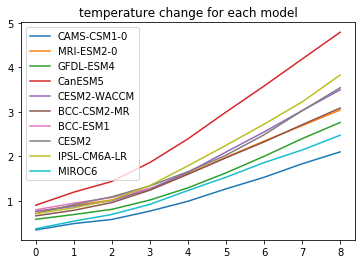

In [17]:
plt.plot(dt)
plt.title('temperature change for each model')
plt.legend(modelnames)

In [18]:
# Function to get mean and variability and their changes
def mean_var_calc(data_tmp,seas='all',weights_in=None):
    print(weights_in)
    # Set if season is 'all'
    if seas=="all":
        seas = ['DJF','MAM','JJA','SON']
    
    # Load
    mu_hist = data_tmp['hist'].load()
    mu_futr = data_tmp['futr'].load()
    

    # Calculate mean of raw series
    mu_hist = (data_tmp['hist'].sel(time=data_tmp['hist'].time.dt.season.isin(seas))
               .pr.mean('time'))
    mu_futr = (data_tmp['futr'].sel(time=data_tmp['futr'].time.dt.season.isin(seas))
               .pr.mean('time'))
    
    # Calculate standard deviation of detrended series
    sd_hist = (xr.apply_ufunc(signal.detrend, data_tmp['hist'].fillna(0),
                                    kwargs={'axis': 0}).where(~data_tmp['hist'].isnull())
               .sel(time=data_tmp['hist'].time.dt.season.isin(seas))
               .std("time"))
    sd_futr = (xr.apply_ufunc(signal.detrend, data_tmp['futr'].fillna(0),
                                    kwargs={'axis': 0}).where(~data_tmp['futr'].isnull())
               .sel(time=data_tmp['futr'].time.dt.season.isin(seas))
               .std("time"))

    # Calculate variance
    var_hist = sd_hist ** 2
    var_futr = sd_futr ** 2
    

    # Area averaging #
    if weights_in is not None:
        print('Using areacella')
        weights = weights_in.areacella
        mu_histG = np.average(mu_hist,weights=weights)
        mu_futrG = np.average(mu_futr,weights=weights)
        var_histG = np.average(var_hist.pr,weights=weights)
        var_futrG = np.average(var_futr.pr,weights=weights)
    else:
        print('Areacella unavailable; ')
        ## if areacella is not available
        ## Use the cosine of the converted latitudes as weights for the average
        latr = np.deg2rad(data_tmp['hist'].lat)
        weights = np.cos(latr)
        mu_histG = np.average(mu_hist.mean("lon"),weights=weights)
        mu_futrG = np.average(mu_futr.mean("lon"),weights=weights)
        var_histG = np.average(var_hist.mean("lon").pr,weights=weights)
        var_futrG = np.average(var_futr.mean("lon").pr,weights=weights)
        
    sd_histG = np.sqrt(var_histG)
    sd_futrG = np.sqrt(var_futrG)
    
    # calculate changes
    dmuG = mu_futrG/mu_histG
#    dmu = mu_futr/mu_hist
#    dmuG = np.average(dmu.mean("lon"),weights=weights.values)
    
    dsd = sd_futr/sd_hist
    dsdG = sd_futrG/sd_histG

    # Out 
    outp = xr.Dataset(
        data_vars = {'mu_hist': mu_hist,
                     'mu_futr': mu_futr,
                     #'dmu':     dmu,
                     'dmuG':    ([],dmuG),
                     'sd_hist': sd_hist.pr,
                     'sd_futr': sd_futr.pr,
                     #'dsd':     dsd.pr,
                     'dsdG':    ([],dsdG)},
        #coords={'lon':            (['lon'],results_tmp['hist'].lon),
        #        'lat':             (['lat'],results_tmp['hist'].lat)}
        )


    return(outp)

In [19]:
source_ids_areacella

['CESM2-WACCM',
 'MIROC6',
 'CanESM5',
 'GFDL-ESM4',
 'MRI-ESM2-0',
 'CESM2',
 'IPSL-CM6A-LR']

In [20]:

data = {}
results = {}

for mod_name in tqdm(source_ids):
    # get a 20 year period
    # try:
        print('\n\nStarting '+mod_name+'\n')
        ds_hist = load_data(df_mon_pr, mod_name, experiment_ids[0]).sel(time=slice('1976', '2005'))
        ds_ssp  = load_data(df_mon_pr, mod_name, experiment_ids[1])
        try: # try getting areacella data
            ds_areacella = load_data(df_areacella, mod_name, experiment_ids[0])

        except: #if not available, flag it as 0. It will use np.cos(lat)
            ds_areacella = None
        
        data[mod_name] = {}
        results[mod_name] = {}
        
        for time_slice in time_slices:
            print('Begin processing time slice '+time_slice[0]+'-'+time_slice[1])
            if ds_ssp.time.max().dt.year+1<int(time_slice[1]):
                print("Future time series only goes until "+str(ds_ssp.time.max().dt.year.values))
                break
            
           # Get corresponding temporal slice of data and stage it
            ds_ssp_tmp = ds_ssp.sel(time=slice(time_slice[0],time_slice[1]))
            data[mod_name]["t"+time_slice[0]] = {'hist':ds_hist,'futr':ds_ssp_tmp}
            
            
            results[mod_name]["t"+time_slice[0]] = {}

## implement this later, for now just do DJF 
#            for seas in seasons:
                # Calculate means, sds,...
            seas='DJF'
            results[mod_name]['t'+time_slice[0]][seas] = mean_var_calc(data[mod_name]['t'+time_slice[0]],
                                                                       seas, weights_in = ds_areacella)
            #print(seas+' processed!')
                
            print(time_slice[0]+'-'+time_slice[1]+' processed!')
            
        print(mod_name+' processed!')
    #except:
    #    print(mod_name+"broken")



Starting CESM2-WACCM

Begin processing time slice 1991-2020
<xarray.Dataset>
Dimensions:    (lat: 192, lon: 288, nbnd: 2)
Coordinates:
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
    lat_bnds   (lat, nbnd) float32 dask.array<chunksize=(192, 2), meta=np.ndarray>
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    lon_bnds   (lon, nbnd) float32 dask.array<chunksize=(288, 2), meta=np.ndarray>
Dimensions without coordinates: nbnd
Data variables:
    areacella  (lat, lon) float32 dask.array<chunksize=(192, 288), meta=np.ndarray>
Attributes:
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   674885.0
    branch_time_in_parent:  20075.0
    case_id:                4
    cesm_casename:          b.e21.BWHIST.f09_g17.CMIP6-historical-WACCM.001
    contact:                cesm_cmip6@ucar.edu
    creation_date:          2019-01-30T23:09:16Z
  

In [21]:
source_ids_areacella

['CESM2-WACCM',
 'MIROC6',
 'CanESM5',
 'GFDL-ESM4',
 'MRI-ESM2-0',
 'CESM2',
 'IPSL-CM6A-LR']

In [22]:
#results

In [23]:
# this is rather brute force, sorry
# dmuG, dsdG - also for different seasons 
dsdG_djf=results
#dsdG_jja=results.copy()
#dmuG_djf=results.copy()
#dmuG_jja=results.copy()
for model in results:
    for timeperiod in results[model]:
        dsdG_djf[model][timeperiod]=results[model][timeperiod]['DJF'].dsdG.values.item(0)
#        dsdG_jja[model][timeperiod]=results[model][timeperiod]['JJA'].dsdG.values.item(0)
#        dmuG_djf[model][timeperiod]=results[model][timeperiod]['DJF'].dmuG.values.item(0)
#        dmuG_jja[model][timeperiod]=results[model][timeperiod]['JJA'].dmuG.values.item(0)
    

In [24]:
pd.DataFrame(dsdG_djf)

,CESM2-WACCM,BCC-CSM2-MR,MIROC6,CanESM5,CAMS-CSM1-0,GFDL-ESM4,MRI-ESM2-0,CESM2,BCC-ESM1,IPSL-CM6A-LR
t1991,1.022184,0.982603,0.983910,1.041476,0.970020,1.035774,0.927374,1.017618,0.963441,1.041305
t2001,1.021454,1.012408,1.027627,1.072001,0.998661,1.034346,0.965627,1.030965,1.002681,1.061704
t2011,1.039816,1.038669,1.004109,1.079521,1.013537,1.030939,0.958772,1.066046,1.018551,1.069258
t2021,1.060674,1.057812,1.006428,1.108786,1.025562,1.034678,0.983005,1.082278,1.032016,1.065308
t2031,1.109779,1.070512,0.993048,1.127890,1.045689,1.057237,1.008734,1.105388,NaN,1.087724
t2041,1.121593,1.073504,1.029917,1.151836,1.043397,1.090690,1.094887,1.121343,NaN,1.111745
t2051,1.145935,1.082534,1.034896,1.170736,1.049514,1.102006,1.142753,1.147366,NaN,1.158009
t2061,1.157643,1.092499,1.038537,1.208483,1.042049,1.095531,1.158891,1.186820,NaN,1.194014
t2071,1.191385,1.105286,1.048009,1.239221,1.059414,1.099062,1.161113,1.213157,NaN,1.237170


In [25]:
pd.DataFrame(dsdG_djf).to_csv('dsdG_djf.csv')

In [26]:
dsdG_djf_new=pd.read_csv('dsdG_djf.csv',index_col=0)
dsdG_djf_new

,CESM2-WACCM,BCC-CSM2-MR,MIROC6,CanESM5,CAMS-CSM1-0,GFDL-ESM4,MRI-ESM2-0,CESM2,BCC-ESM1,IPSL-CM6A-LR
t1991,1.022184,0.982603,0.983910,1.041476,0.970020,1.035774,0.927374,1.017618,0.963441,1.041305
t2001,1.021454,1.012408,1.027627,1.072001,0.998661,1.034346,0.965627,1.030965,1.002681,1.061704
t2011,1.039816,1.038669,1.004109,1.079521,1.013537,1.030939,0.958772,1.066046,1.018551,1.069258
t2021,1.060674,1.057812,1.006428,1.108786,1.025562,1.034678,0.983005,1.082278,1.032016,1.065308
t2031,1.109779,1.070512,0.993048,1.127890,1.045689,1.057237,1.008734,1.105388,NaN,1.087724
t2041,1.121593,1.073504,1.029917,1.151836,1.043397,1.090690,1.094887,1.121343,NaN,1.111745
t2051,1.145935,1.082534,1.034896,1.170736,1.049514,1.102006,1.142753,1.147366,NaN,1.158009
t2061,1.157643,1.092499,1.038537,1.208483,1.042049,1.095531,1.158891,1.186820,NaN,1.194014
t2071,1.191385,1.105286,1.048009,1.239221,1.059414,1.099062,1.161113,1.213157,NaN,1.237170


In [27]:
dsdG_djf=dsdG_djf_new.to_dict()

In [28]:
dsdG_djf_np=np.zeros((len(time_slices),len(dsdG_djf)))*np.nan 

In [29]:
modelcount=0
modelnames=[]
for model in tresults_dict:
    modelnames.append(model)
    timecount=0
    for timeperiod in dsdG_djf[model]:
        dsdG_djf_np[timecount,modelcount]=dsdG_djf[model][timeperiod]
        timecount=timecount+1
    modelcount=modelcount+1

In [30]:
dsdG_djf_np

array([[0.97001951, 0.92737365, 1.03577399, 1.04147601, 1.0221839 ,
        0.98260308, 0.96344096, 1.01761818, 1.0413053 , 0.98390967],
       [0.99866134, 0.9656269 , 1.0343461 , 1.07200062, 1.02145362,
        1.01240815, 1.00268099, 1.03096521, 1.06170416, 1.02762699],
       [1.01353749, 0.95877194, 1.03093898, 1.07952094, 1.03981602,
        1.03866912, 1.01855125, 1.06604552, 1.06925786, 1.00410914],
       [1.02556207, 0.98300475, 1.03467751, 1.10878611, 1.06067407,
        1.05781245, 1.03201613, 1.08227813, 1.06530845, 1.00642753],
       [1.04568893, 1.00873399, 1.05723727, 1.12788951, 1.10977948,
        1.07051213,        nan, 1.10538793, 1.08772409, 0.99304754],
       [1.04339748, 1.0948875 , 1.09069026, 1.1518364 , 1.121593  ,
        1.07350369,        nan, 1.12134326, 1.11174512, 1.02991724],
       [1.04951387, 1.14275289, 1.10200596, 1.17073643, 1.14593542,
        1.08253419,        nan, 1.1473664 , 1.15800941, 1.03489614],
       [1.04204886, 1.15889072, 1.0955305

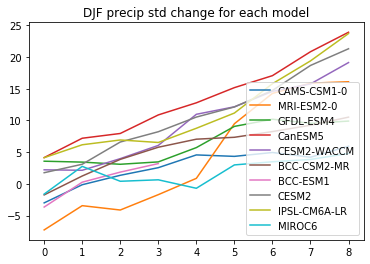

In [31]:
plt.plot((dsdG_djf_np-1)*100)
plt.title('DJF precip std change for each model')
plt.legend(modelnames)